In [29]:
# Only needed if you plan to run sentiment or wordcloud in Colab.
# Run this once in Colab to install the extra packages.
!pip install -q textblob vaderSentiment wordcloud nltk
# NLTK stopwords may be downloaded later when used.



In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob


In [31]:
df = pd.read_csv('student_feedback.csv')
print("Rows:", len(df))
print("Columns:", len(df.columns))
print("Column names:", list(df.columns))
display(df.head(8))
df.info()

Rows: 1001
Columns: 10
Column names: ['Unnamed: 0', 'Student ID', 'Well versed with the subject', 'Explains concepts in an understandable way', 'Use of presentations', 'Degree of difficulty of assignments', 'Solves doubts willingly', 'Structuring of the course', 'Provides support for students going above and beyond', 'Course recommendation based on relevance']


,Unnamed: 0,Student ID,Well versed with the subject,Explains concepts in an understandable way,Use of presentations,Degree of difficulty of assignments,Solves doubts willingly,Structuring of the course,Provides support for students going above and beyond,Course recommendation based on relevance
0,0,340,5,2,7,6,9,2,1,8
1,1,253,6,5,8,6,2,1,2,9
2,2,680,7,7,6,5,4,2,3,1
3,3,806,9,6,7,1,5,9,4,6
4,4,632,8,10,8,4,6,6,9,9
5,5,832,7,2,7,8,3,5,1,4
6,6,772,9,3,5,2,10,3,8,1
7,7,961,9,8,7,4,4,3,3,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 10 columns):
 #   Column                                                Non-Null Count  Dtype
---  ------                                                --------------  -----
 0   Unnamed: 0                                            1001 non-null   int64
 1   Student ID                                            1001 non-null   int64
 2   Well versed with the subject                          1001 non-null   int64
 3   Explains concepts in an understandable way            1001 non-null   int64
 4   Use of presentations                                  1001 non-null   int64
 5   Degree of difficulty of assignments                   1001 non-null   int64
 6   Solves doubts willingly                               1001 non-null   int64
 7   Structuring of the course                             1001 non-null   int64
 8   Provides support for students going above and beyond  1001 non-null   int64
 9

# Rename messy column names to short keys

In [32]:
# Example: map long column names to short keys for easier coding
rename_map = {
    'Well versed with the subject': 'well_versed',
    'Explains concepts in an understandable way': 'explains',
    'Use of presentations': 'presentations',
    'Degree of difficulty of assignments': 'difficulty',
    'Solves doubts willingly': 'solves_doubts',
    'Structuring of the course': 'structure',
    'Provides support for students going above and beyond': 'support_above',
    'Course recommendation based on relevance': 'recommendation'
}
df = df.rename(columns=rename_map)


# Identify rating columns automatically

In [33]:
# remove id/index columns
exclude = ['Unnamed: 0', 'Student ID']
rating_cols = [c for c in df.columns if c not in exclude and df[c].dtype in ['int64','float64']]
print("Detected rating columns:", rating_cols)


Detected rating columns: ['well_versed', 'explains', 'presentations', 'difficulty', 'solves_doubts', 'structure', 'support_above', 'recommendation']


# Check scale (min/max) for each rating column

In [34]:
min_max = pd.DataFrame({
    'min': df[rating_cols].min(),
    'max': df[rating_cols].max(),
    'mean': df[rating_cols].mean()
}).sort_values('mean', ascending=False)
display(min_max)


,min,max,mean
well_versed,5,10,7.497502
explains,2,10,6.081918
presentations,4,8,5.942058
support_above,1,10,5.662338
structure,1,10,5.636364
recommendation,1,10,5.598402
solves_doubts,1,10,5.474525
difficulty,1,10,5.430569


# Rescale all rating columns to 1–5

In [35]:
def rescale_series(s, new_min=1, new_max=5):
    old_min = s.min()
    old_max = s.max()
    if old_max == old_min:
        return s  # nothing to rescale
    return ((s - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

for c in rating_cols:
    df[c + '_scaled'] = rescale_series(df[c], 1, 5)

scaled_cols = [c+'_scaled' for c in rating_cols]
display(df[scaled_cols].describe().T)


,count,mean,std,min,25%,50%,75%,max
well_versed_scaled,1001.0,2.998002,1.354399,1.0,1.800000,3.400000,4.200000,5.0
explains_scaled,1001.0,3.040959,1.298584,1.0,2.000000,3.000000,4.000000,5.0
presentations_scaled,1001.0,2.942058,1.415853,1.0,2.000000,3.000000,4.000000,5.0
difficulty_scaled,1001.0,2.969142,1.275132,1.0,1.888889,2.777778,4.111111,5.0
solves_doubts_scaled,1001.0,2.988678,1.277621,1.0,1.888889,3.222222,4.111111,5.0
structure_scaled,1001.0,3.060606,1.297872,1.0,1.888889,3.222222,4.111111,5.0
support_above_scaled,1001.0,3.072150,1.285195,1.0,1.888889,3.222222,4.111111,5.0
recommendation_scaled,1001.0,3.043734,1.282941,1.0,1.888889,3.222222,4.111111,5.0


# Create a composite satisfaction score

In [36]:
# Use scaled columns if present, otherwise use rating_cols
use_cols = scaled_cols if len(scaled_cols) > 0 else rating_cols
df['satisfaction_score'] = df[use_cols].mean(axis=1)
df[['satisfaction_score']].describe()


,satisfaction_score
count,1001.000000
mean,3.014416
std,0.452492
min,1.769444
25%,2.709722
50%,2.993056
75%,3.340278
max,4.222222


# Exploratory Data Analysis (EDA):

# Mean per question, top & bottom

In [37]:
means = df[use_cols].mean().sort_values(ascending=False)
print("Means per question (descending):")
print(means)
print("\nTop 3 questions (highest mean):")
print(means.head(3))
print("\nBottom 3 questions (lowest mean):")
print(means.tail(3))


Means per question (descending):
support_above_scaled     3.072150
structure_scaled         3.060606
recommendation_scaled    3.043734
explains_scaled          3.040959
well_versed_scaled       2.998002
solves_doubts_scaled     2.988678
difficulty_scaled        2.969142
presentations_scaled     2.942058
dtype: float64

Top 3 questions (highest mean):
support_above_scaled     3.072150
structure_scaled         3.060606
recommendation_scaled    3.043734
dtype: float64

Bottom 3 questions (lowest mean):
solves_doubts_scaled    2.988678
difficulty_scaled       2.969142
presentations_scaled    2.942058
dtype: float64


# Plot mean ratings per question (matplotlib)

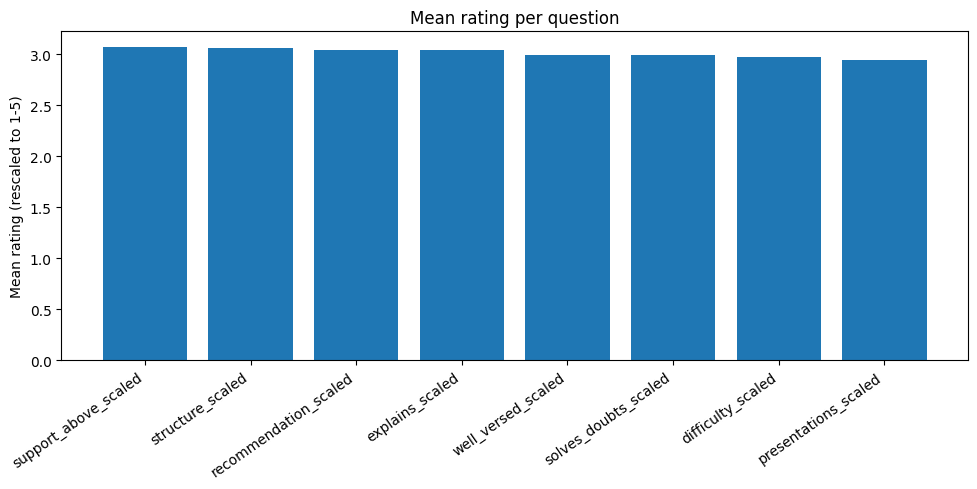

<Figure size 640x480 with 0 Axes>

In [38]:

means_df = means.reset_index()
means_df.columns = ['question', 'mean']
plt.figure(figsize=(10,5))
plt.bar(means_df['question'], means_df['mean'])
plt.xticks(rotation=35, ha='right')
plt.ylabel('Mean rating (rescaled to 1-5)')
plt.title('Mean rating per question')
plt.tight_layout()
plt.show()
# Save figure to include in report
plt.savefig('mean_ratings.png', bbox_inches='tight')


# Distribution of overall satisfaction (histogram)

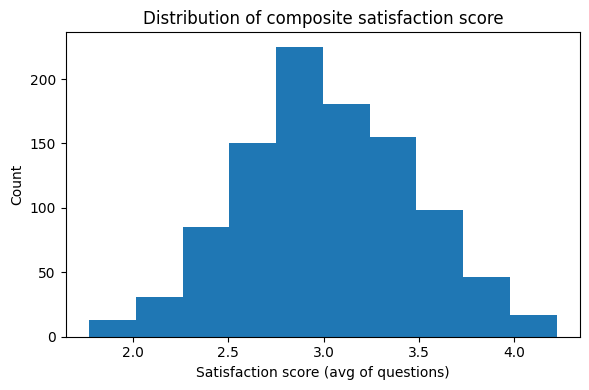

<Figure size 640x480 with 0 Axes>

In [39]:
plt.figure(figsize=(6,4))
plt.hist(df['satisfaction_score'].dropna(), bins=10)
plt.xlabel('Satisfaction score (avg of questions)')
plt.ylabel('Count')
plt.title('Distribution of composite satisfaction score')
plt.tight_layout()
plt.show()
plt.savefig('satisfaction_dist.png', bbox_inches='tight')


# Pie chart of average satisfaction per question

In [46]:
exclude = ['Unnamed: 0', 'Student ID']
rating_cols = [c for c in df.columns if c not in exclude]

# Calculate mean rating for each question
mean_ratings = df[rating_cols].mean().sort_values(ascending=False)



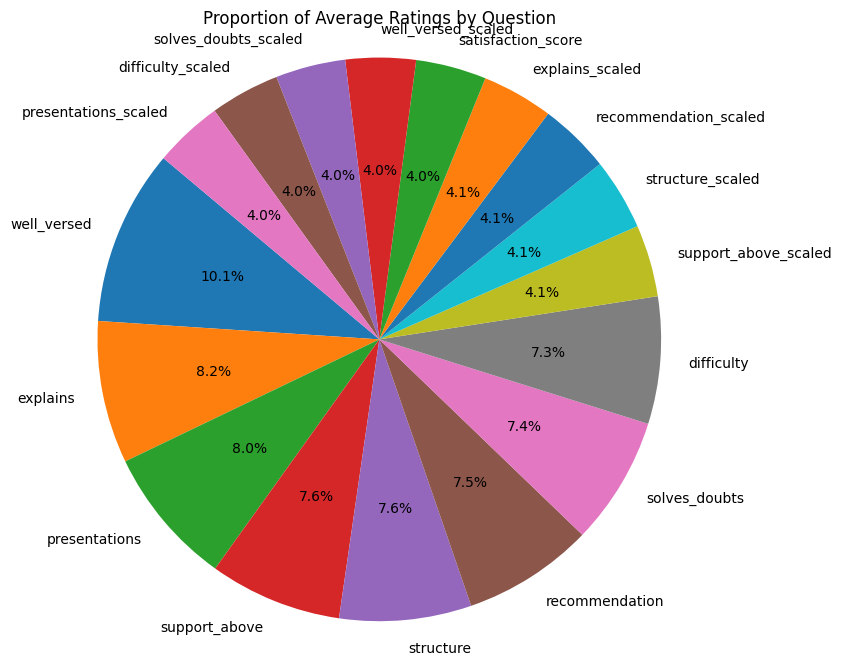

<Figure size 640x480 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt

# Define rating columns and calculate mean ratings
exclude = ['Unnamed: 0', 'Student ID']
rating_cols = [c for c in df.columns if c not in exclude]
mean_ratings = df[rating_cols].mean().sort_values(ascending=False)

# Pie chart of average ratings per question
plt.figure(figsize=(8,8))
plt.pie(mean_ratings, labels=mean_ratings.index, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Average Ratings by Question")
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()
plt.savefig('average satisfaction per question.png', bbox_inches='tight')


# Correlation matrix (and plot)

                       well_versed_scaled  explains_scaled  \
well_versed_scaled                   1.00             0.01   
explains_scaled                      0.01             1.00   
presentations_scaled                -0.02            -0.01   
difficulty_scaled                   -0.01             0.03   
solves_doubts_scaled                -0.06            -0.03   
structure_scaled                    -0.03             0.01   
support_above_scaled                 0.03            -0.00   
recommendation_scaled               -0.02             0.01   

                       presentations_scaled  difficulty_scaled  \
well_versed_scaled                    -0.02              -0.01   
explains_scaled                       -0.01               0.03   
presentations_scaled                   1.00               0.02   
difficulty_scaled                      0.02               1.00   
solves_doubts_scaled                  -0.04               0.01   
structure_scaled                      -0.02  

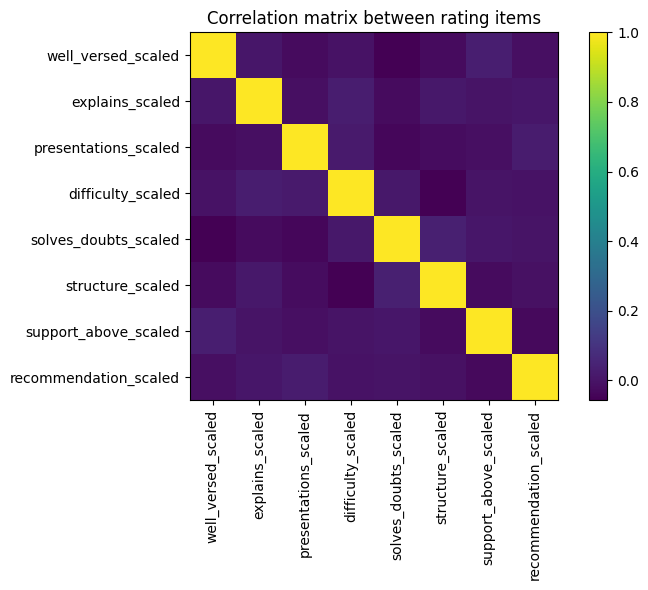

<Figure size 640x480 with 0 Axes>

In [40]:
corr = df[use_cols].corr()
print(corr.round(2))
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(use_cols)), use_cols, rotation=90)
plt.yticks(range(len(use_cols)), use_cols)
plt.title('Correlation matrix between rating items')
plt.tight_layout()
plt.show()
plt.savefig('correlations.png', bbox_inches='tight')


# Sentiment analysis & comments

# TextBlob sentiment (easy)

In [41]:


if 'comments' in df.columns:
    df['tb_polarity'] = df['comments'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
    # polarity: -1 (negative) ... 0 (neutral) ... +1 (positive)
    def tb_label(x):
        if x > 0.2:
            return 'positive'
        elif x < -0.2:
            return 'negative'
        else:
            return 'neutral'
    df['tb_sentiment'] = df['tb_polarity'].apply(tb_label)
    display(df[['comments','tb_polarity','tb_sentiment']].head(6))
else:
    print("No 'comments' column found. Add a text column named 'comments' and re-run.")


No 'comments' column found. Add a text column named 'comments' and re-run.


# VADER (works well for short feedback)

In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

if 'comments' in df.columns:
    df['vader_compound'] = df['comments'].astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])
    def vader_label(x):
        if x >= 0.05:
            return 'positive'
        elif x <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    df['vader_sentiment'] = df['vader_compound'].apply(vader_label)
    display(df[['comments','vader_compound','vader_sentiment']].head(6))


# Compare TextBlob & VADER counts

In [43]:
if 'comments' in df.columns:
    print("TextBlob summary:\n", df['tb_sentiment'].value_counts())
    print("VADER summary:\n", df['vader_sentiment'].value_counts())


# Word cloud of most common complaints / topics

In [44]:
# Only run if comments present
if 'comments' in df.columns:
    import nltk
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    from wordcloud import WordCloud
    stop = set(stopwords.words('english'))

    text = " ".join(str(s) for s in df['comments'].dropna().astype(str))
    # basic clean: lowercase and remove very short tokens
    tokens = [w.lower() for w in text.split() if len(w) > 2 and w.lower() not in stop]
    clean_text = " ".join(tokens)

    wc = WordCloud(width=800, height=400).generate(clean_text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word cloud of student comments')
    plt.show()
    wc.to_file('/content/wordcloud_comments.png')
else:
    print("No comments found. Add 'comments' column to generate wordcloud.")


No comments found. Add 'comments' column to generate wordcloud.
